#### pre-processing geo, map & urban characteristics

In [1]:
import sys
import os
#import json
import csv
import pandas as pd
import numpy as np


from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BdeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination

#from mpl_toolkits.mplot3d import Axes3D

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
from sklearn.cluster import KMeans
import sklearn.datasets as data
import sklearn.cluster as cluster
from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
#from sklearn.neighbors import LocalOutlierFactor

#from sklearn.datasets.samples_generator import make_blobs
from itertools import compress

from subprocess import check_output
#from wordcloud import WordCloud, STOPWORDS


#import time

import scipy as sy
from scipy import stats
from pylab import rcParams

import geopandas as gp
from fiona.crs import from_epsg
import shapely as shp
from shapely.geometry import Point

from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
HHI = pd.read_csv('HH_Income.csv')

In [15]:
population = pd.read_csv('Stadiums_Loc_Pop.csv')

In [20]:
geo_stats = population.merge(HHI,on='geo_location',how='inner')

In [33]:
geo_stats

,game_center,geo_location,population_2015,land_miles,density_per_mile,HH_Income
0,Golden 1 Center,"SACRAMENTO, CA","490,712.00",97.90,"5,012.38","46,106.00"
1,Greensboro Coliseum,"Greensboro, NC","269,666.00",126.48,"2,132.00","40,913.00"
2,Mullins Center,"Amherst, MA","37,819.00",27.80,"1,360.40","52,537.00"
3,Air Canada Centre,"Toronto, ON","2,731,571.00",243.33,"11,225.79","58,381.00"
4,United Center,"Chicago, IL","2,720,546.00",227.60,"11,953.19","51,046.00"
5,Bankers Life Fieldhouse,"Indianapolis, IN","853,173.00",361.40,"2,360.74","45,548.00"
6,BMO Harris Bradley Center,"Milwaukee, WI","559,121.00",187.70,"2,978.80","46,132.00"
7,The Palace of Auburn Hills,"Detroit, MI","677,116.00",138.80,"4,878.36","49,160.00"
8,Philips Arena,"Atlanta, GA","463,878.00",133.20,"3,482.57","51,948.00"
9,Wells Fargo Center,"Philadelphia, PA","1,567,442.00",134.10,"11,688.61","47,528.00"


In [21]:
stadium_lonlat = pd.read_csv('Stadium_Lon_Lat.csv')
stadium_lonlat.drop(['Unnamed: 0','Unnamed: 4'],axis=1,inplace=True)

In [ ]:
#station_city = population[['game_center','geo_location']]
#station_city = station_city.drop_duplicates()
#station_city.reset_index(drop = True, inplace = True)

In [23]:
games_g = geo_stats.merge(stadium_lonlat,on='game_center',how='outer')

In [24]:
geometry = [Point(xy) for xy in zip(games_g['lon'], games_g['lat'])]
games_g = gp.GeoDataFrame(games_g, geometry=geometry)
games_g.crs = {'init': 'epsg:4326'}
games_g = games_g.to_crs(epsg=2163)
games_g.crs

{'init': 'epsg:2163', 'no_defs': True}

In [25]:
us_urb_shp = gp.read_file("cb_2016_us_ua10_500k.shp")
us_urb_shp = us_urb_shp.to_crs(epsg=2163)

us_states_shp = gp.read_file("cb_2016_us_state_500k.shp")
us_states_shp = us_states_shp.to_crs(epsg=2163)
us_states_shp = us_states_shp[(us_states_shp.NAME != 'Hawaii') & 
                              (us_states_shp.NAME != 'United States Virgin Islands') &
                              (us_states_shp.NAME != 'Commonwealth of the Northern Mariana Islands') &
                              (us_states_shp.NAME != 'Commonwealth of the Northern Mariana Islands') &
                              (us_states_shp.NAME != 'Guam') &
                              (us_states_shp.NAME != 'Hawaii') &
                              (us_states_shp.NAME != 'American Samoa') &
                              (us_states_shp.NAME != 'Alaska')]


print us_states_shp.crs, us_urb_shp.crs

{'init': 'epsg:2163', 'no_defs': True} {'init': 'epsg:2163', 'no_defs': True}


In [26]:
urban_areas = gp.sjoin(us_urb_shp,games_g, op='contains') 

In [27]:
urban_areas.head(3)

,AFFGEOID10,ALAND10,AWATER10,GEOID10,LSAD10,NAME10,UACE10,UATYP10,geometry,index_right,game_center,geo_location,population_2015,land_miles,density_per_mile,HH_Income,lon,lat
172,400C100US15670,1919692462,92391183,15670,75,"Charlotte, NC--SC",15670,U,(POLYGON ((1764560.563326363 -908174.160956141...,21,Spectrum Center,"Charlotte, NC","132,609.00",109.0,"1,216.60","46,119.00",-80.839235,35.225143
202,400C100US78904,1356901554,24532171,78904,75,"San Francisco--Oakland, CA",78904,U,(POLYGON ((-1918879.865411957 -514372.56760230...,20,ORACLE Arena,"Oakland, CA","419,267.00",55.9,"7,500.30","63,024.00",-122.203049,37.750292
314,400C100US78580,1546746851,10023168,78580,75,"San Antonio, TX",78580,U,(POLYGON ((184514.3364000619 -1686972.49897577...,13,AT&T Center,"San Antonio, TX","1,469,845.00",460.9,"3,189.08","39,140.00",-98.437445,29.427071


In [28]:
games_g.head(3)

,game_center,geo_location,population_2015,land_miles,density_per_mile,HH_Income,lon,lat,geometry
0,Golden 1 Center,"SACRAMENTO, CA","490,712.00",97.90,"5,012.38","46,106.00",-121.499619,38.580641,POINT (-1846055.443413501 -472583.6504320072)
1,Greensboro Coliseum,"Greensboro, NC","269,666.00",126.48,"2,132.00","40,913.00",-79.825550,36.059723,POINT (1797594.52121978 -775859.5169488323)
2,Mullins Center,"Amherst, MA","37,819.00",27.80,"1,360.40","52,537.00",-72.533446,42.389382,POINT (2203570.831694617 86164.26556559556)


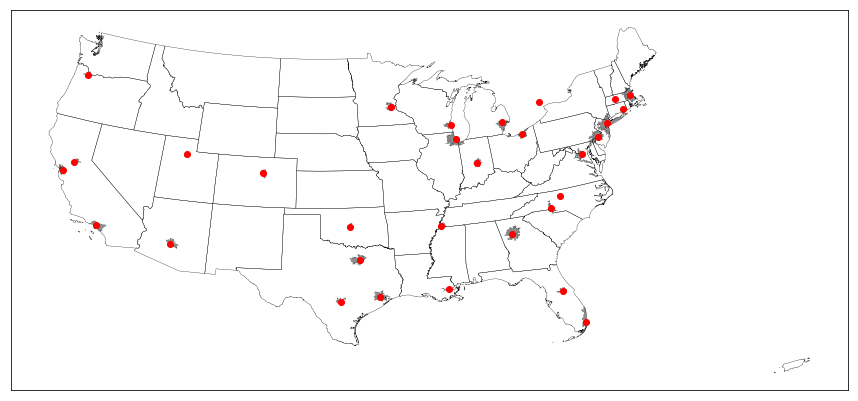

In [29]:
f, ax = plt.subplots(figsize=(15,7))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
urban_areas.geometry.plot(alpha=1,color='grey',linewidth=0.1,ax=ax)
us_states_shp.geometry.plot(alpha=.1,color='white',linewidth=0.3,ax=ax)
games_g.geometry.plot(markersize=6,color='red',label = 'Stadiums', ax=ax)

In [30]:
population.to_csv('Std_Loc_Pop.csv')

In [31]:
stadium_lonlat.to_csv('stadium_coord.csv')

In [32]:
games_g.to_csv('city_charac.csv')

In [34]:
HHI.to_csv('Std_Loc_HHI.csv')

In [36]:
geo_stats.to_csv('Std_City_Stats.csv')